In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install segmentation-models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.2 MB/s eta 0:00:00


In [3]:
import tensorflow as tf
import keras

print(tf.__version__)
print(keras.__version__)

2.14.0
2.14.0


In [4]:
# Import libraries
import sys
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras import backend as K
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [5]:
train_original_2D = np.load('/content/drive/MyDrive/2DPart/2Dnpy/2D_train_original.npy')
train_mask_2D = np.load('/content/drive/MyDrive/2DPart/2Dnpy/2D_train_mask.npy')
validation_original_2D = np.load('/content/drive/MyDrive/2DPart/2Dnpy/2D_validation_original.npy')
validation_mask_2D = np.load('/content/drive/MyDrive/2DPart/2Dnpy/2D_validation_mask.npy')
test_original_2D = np.load('/content/drive/MyDrive/2DPart/2Dnpy/2D_test_original.npy')
test_mask_2D = np.load('/content/drive/MyDrive/2DPart/2Dnpy/2D_test_mask.npy')

In [17]:
print("Shape of the data:", test_original_2D.shape)
print("Shape of the data:", train_mask_2D.shape)

Shape of the data: (70, 512, 512, 3)
Shape of the data: (470, 512, 512, 2)


In [ ]:
def add_gaussian_noise(images, sigma=25):
    noisy_images = np.empty_like(images, dtype=np.float32)

    for i in range(images.shape[0]):
        gauss = np.random.normal(0, sigma, images[i].shape)
        noisy = np.clip(images[i] + gauss, 0, 255)
        noisy_images[i] = noisy

    return noisy_images.astype(np.uint8)

In [ ]:
train_original_2D = add_gaussian_noise(train_original_2D)

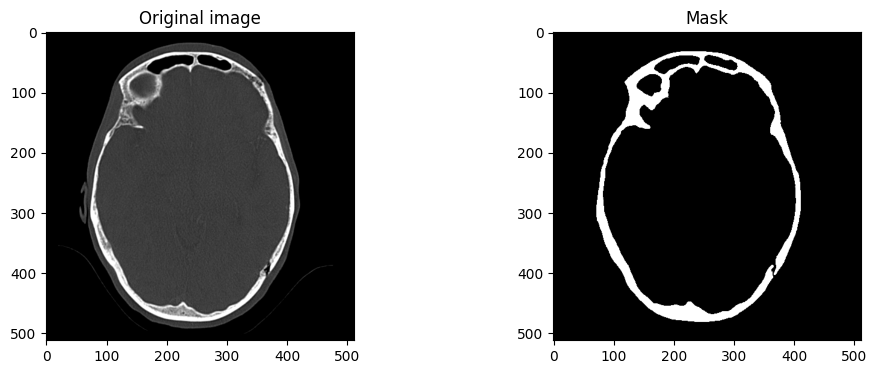

In [7]:
# Check the images 2D
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].imshow(train_original_2D[467,:,:,0], cmap='gray')
axes[0].set_title('Original image')

axes[1].imshow(train_mask_2D[467,:,:,0], cmap='gray')
axes[1].set_title('Mask')

plt.show()

In [8]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = Lambda(lambda x: x / 255)(inputs)
    #s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.summary()

    return model


In [9]:
LR = 0.0001
optim = tf.keras.optimizers.Adam(LR)

In [10]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
from tensorflow import keras
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [11]:
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

In [12]:
metrics = [sm.metrics.IOUScore(threshold=0.5)]

In [13]:
model = simple_unet_model(IMG_HEIGHT=512,
                          IMG_WIDTH=512,
                          IMG_CHANNELS=1)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 1)]        0         []                            
                                                                                                  
 lambda (Lambda)             (None, 512, 512, 1)          0         ['input_1[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 512, 512, 16)         160       ['lambda[0][0]']              
                                                                                                  
 dropout (Dropout)           (None, 512, 512, 16)         0         ['conv2d[0][0]']              
                                                                                              

In [14]:
model.compile(optimizer = optim, loss=dice_loss, metrics=metrics)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 1)]        0         []                            
                                                                                                  
 lambda (Lambda)             (None, 512, 512, 1)          0         ['input_1[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 512, 512, 16)         160       ['lambda[0][0]']              
                                                                                                  
 dropout (Dropout)           (None, 512, 512, 16)         0         ['conv2d[0][0]']              
                                                                                              

In [15]:
from tensorflow.keras.callbacks import Callback

In [16]:
class SavePredictionsCallback(Callback):
    def __init__(self, validation_data, save_dir):
        super(SavePredictionsCallback, self).__init__()
        self.validation_data = validation_data
        self.save_dir = save_dir

    def on_epoch_end(self, epoch, logs=None):
        predicted_masks = self.model.predict(self.validation_data[0])

        for i in range(len(self.validation_data[0])):
            self.save_or_visualize_results(
                self.validation_data[0][i],
                self.validation_data[1][i],
                predicted_masks[i],
                epoch,
                i
            )

    def save_or_visualize_results(self, input_image, true_mask, predicted_mask, epoch, sample_idx):
        fig, axes = plt.subplots(1, 3, figsize=(12, 4))

        axes[0].imshow(input_image, cmap='gray')
        axes[0].set_title('Input Image')

        axes[1].imshow(true_mask, cmap='gray')
        axes[1].set_title('True Mask')

        axes[2].imshow(predicted_mask, cmap='gray')
        axes[2].set_title('Predicted Mask')

        plt.savefig(os.path.join(self.save_dir, f'epoch_{epoch}_sample_{sample_idx}.png'))
        plt.close()

In [18]:
save_dir = '/content/drive/MyDrive/2DPart/Model_training_prediction/vanilla2D'
os.makedirs(save_dir, exist_ok=True)

save_predictions_callback = SavePredictionsCallback(validation_data=(validation_original_2D[:,:,:,0], validation_mask_2D[:,:,:,0]), save_dir=save_dir)

In [19]:
history = model.fit(train_original_2D[:,:,:,0],
          train_mask_2D[:,:,:,0],
          batch_size = 10,
          epochs = 50,
          verbose = 1,
          validation_data=(validation_original_2D[:,:,:,0], validation_mask_2D[:,:,:,0]),
          callbacks=[save_predictions_callback])

Epoch 1/50
 6/47 [==>...........................] - ETA: 5s - loss: 0.8455 - iou_score: 0.0620

47/47 [==============================] - 55s 782ms/step - loss: 0.7879 - iou_score: 0.1091 - val_loss: 0.7386 - val_iou_score: 0.1844
Epoch 2/50
47/47 [==============================] - 33s 710ms/step - loss: 0.7353 - iou_score: 0.1956 - val_loss: 0.7670 - val_iou_score: 0.3914
Epoch 3/50
47/47 [==============================] - 32s 690ms/step - loss: 0.6675 - iou_score: 0.4555 - val_loss: 0.3857 - val_iou_score: 0.4806
Epoch 4/50
47/47 [==============================] - 33s 710ms/step - loss: 0.2674 - iou_score: 0.5848 - val_loss: 0.4138 - val_iou_score: 0.4099
Epoch 5/50
47/47 [==============================] - 30s 658ms/step - loss: 0.1879 - iou_score: 0.6846 - val_loss: 0.4498 - val_iou_score: 0.3749
Epoch 6/50
47/47 [==============================] - 32s 693ms/step - loss: 0.1667 - iou_score: 0.7160 - val_loss: 0.4444 - val_iou_score: 0.3808
Epoch 7/50
47/47 [==============================] - 33s 705ms/step - loss: 0.1544 - iou_score: 0.7347 - val_loss: 0.3683 - val_iou_score: 0.4

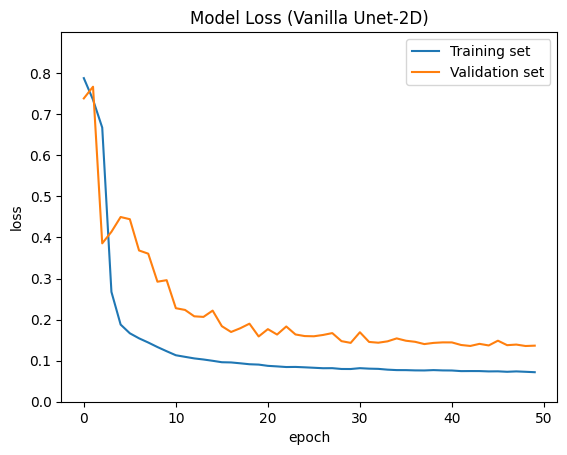

In [20]:
# Plot loss function
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss, label='loss')
plt.plot(val_loss, label='val_loss')
plt.ylim(0, 0.9)
plt.yticks(np.arange(0, 0.9, 0.1))
plt.title('Model Loss (Vanilla Unet-2D)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training set', 'Validation set'], loc='upper right')

In [21]:
model.save('/content/drive/MyDrive/2DPart/2Dmodel/vanilla_unet2d_totalLoss_50.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
